## <font style='font-size: 30px;'> Avaliação do modelo de segunda ordem </font> <hr style='line: 2px solid;'>

A função de transferência média da planta de pressão é dada por, segundo a análise feita é:

$$
\zeta = 0.3346 \\
\omega_n = 4.4971 \\
k = 1.3885
$$

O que nos dá a seguinte função transferência:

$$
G(s) \approx 1.3885 \cdot \frac{20.223}{s^2 + 3s + 20.223}
$$

Serão os seguintes requisitos:

- $e_{ss} = 0.02$
- $T_s(2\%) < 1s$
- $M_p < 20 \%$

Simulação abaixo...

                    Valor
Parâmetro                
RiseTime           0.1799
SettlingTime       2.4825
SettlingMin        0.4367
SettlingMax        0.8715
Overshoot         49.9097
Undershoot         0.0000
Peak               0.8715
PeakTime           0.4677
SteadyStateValue   0.5813


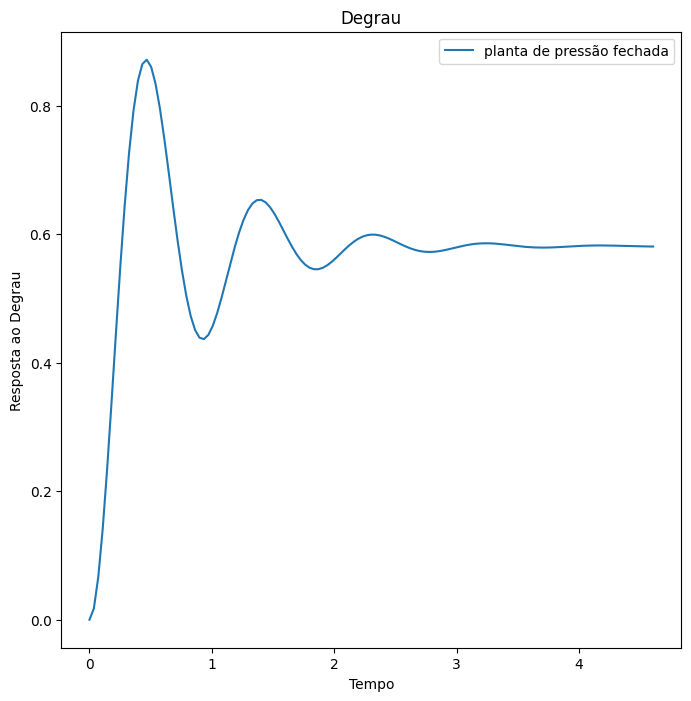

In [60]:
malha_aberta = ct.TransferFunction([28.0796],[1, 3, 20.223])
malha_fechada = ct.feedback(planta_pressao, 1)
parametros = obter_plot_degrau({'planta de pressão fechada':malha_fechada}, amortecimento=0.02)
parametros

## <font style='font-size: 30px;'> Kc para requisito de Erro estacionário </font> <hr style='line: 2px solid;'>

A primeira coisa que iremos fazer é resolver nosso requisito de erro no estado estacionário. Ele é calculado para degrau unitário e é proporcional a uma constante $K_p$, em sistemas do tipo 0 — que é o caso. Logo:

$$e_{ss} = 0.02 = \frac{1}{1+K_p} → K_p = 49$$

O ganho do controlador deve ser:

$$ K_c = \frac{K}{K_p} → \frac{1.3885}{49} → \boxed{K_c = 35.2899} $$

Vê-se na simulação que de fato garantimos o erro, mas nenhum dos outros requisitos. Então vamos para o projeto do compensador.

Simulação abaixo...

                    Valor
Parâmetro                
RiseTime           0.0395
SettlingTime       2.5830
SettlingMin        0.2517
SettlingMax        1.8188
Overshoot         85.5919
Undershoot         0.0000
Peak               1.8188
PeakTime           0.1027
SteadyStateValue   0.9800


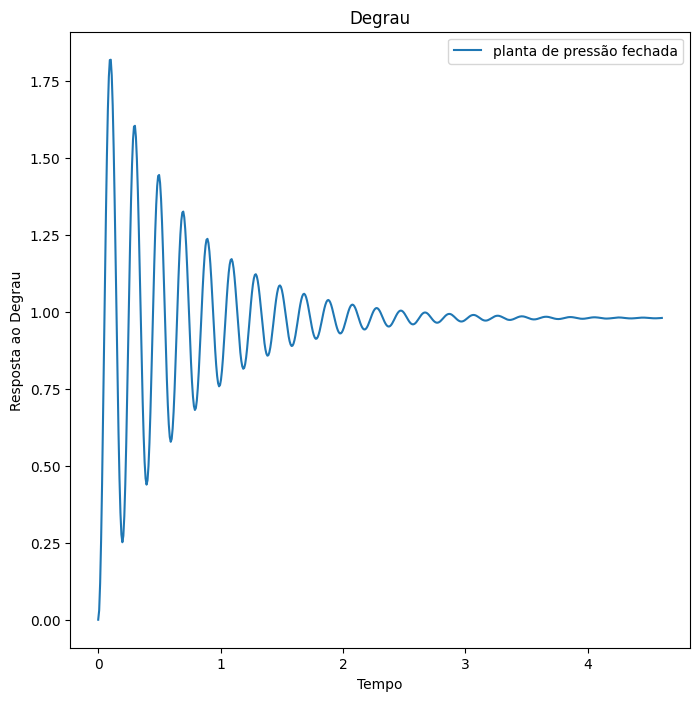

In [64]:
malha_aberta = ct.TransferFunction([35.2899 * 28.0796],[1, 3, 20.223])
malha_fechada = ct.feedback(malha_aberta, 1)
parametros = obter_plot_degrau({'planta de pressão fechada':malha_fechada}, amortecimento=0.02)
parametros

## <font style='font-size: 30px;'> Análise lugar das raízes — Compensador de avanço </font> <hr style='line: 2px solid;'>

> 1. Defina qual é o seu par complexo conjugado para produzir suas especificações

Encontre o par de polos complexos e conjugados que pertencem à um lugar das raizes que cumprem os requisitos definidos. Eu vou considerar considerar uma folga para garantir que atingiremos os requisitos. Então, será:

- $e_{ss}$ = 0.02
- $M_p = 0.16$
- $T_s = 0.8$

In [26]:
s = obter_conjulgados_dominantes(Mp=0.16, Ts=1, xi=0.8)
s[0]

(-4+3j)

> 2. Ache o polo em função do angulo a ser compensado e encontre seu compensador. 

Uma abordagem é cancelar os dois polos conjugados com dois zeros nas mesmas posições. Depois posicionar estratégicamente um polo na origem e outro em -8.

In [41]:
num, den = obter_compensador_LR2([28.0796], [1, 3, 20.223], polos_add=[1, 8, 0], zeros_add=[1, 3, 20.223])


 Sua malha sem compensador é:
 
      28.08
-----------------
s^2 + 3 s + 20.22


 Seu compensador é:
 
s^2 + 3 s + 20.22
-----------------
    s^2 + 8 s


 Seu sistema compensado é:
 
   28.08 s^2 + 84.24 s + 567.9
----------------------------------
s^4 + 11 s^3 + 44.22 s^2 + 161.8 s



> 3. Verifique o lugar das raízes.

In [42]:
malha_aberta  = ct.TransferFunction(num, den)
malha_fechada = ct.feedback(malha_aberta, 1)
malha_fechada

TransferFunction(array([ 28.0796   ,  84.2388   , 567.8537508]), array([  1.       ,  11.       ,  72.3026   , 246.0228   , 567.8537508]))

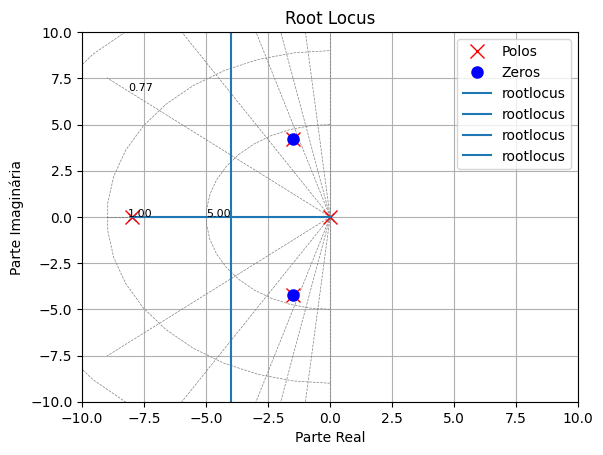


 Polos : 
-8.0000+0.0000j
-1.5000+4.2395j
-1.5000-4.2395j
0.0000+0.0000j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [43]:
obter_lugar_raizes(num, den, l_inf=10, l_sup=10)

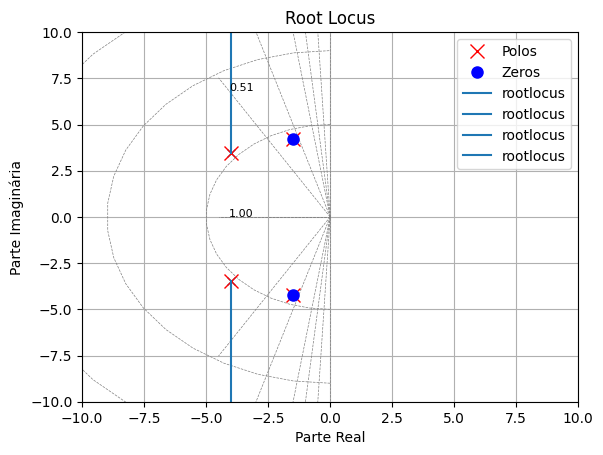


 Polos : 
-4.0000+3.4756j
-4.0000-3.4756j
-1.5000+4.2395j
-1.5000-4.2395j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [44]:
obter_lugar_raizes(malha_fechada.num, malha_fechada.den, l_inf=10, l_sup=10)

> 4. Simule a resposta ao degrau.

                   Valor
Parâmetro               
RiseTime          0.4468
SettlingTime      1.0997
SettlingMin       0.9167
SettlingMax       1.0269
Overshoot         2.6858
Undershoot        0.0000
Peak              1.0269
PeakTime          0.8935
SteadyStateValue  1.0000


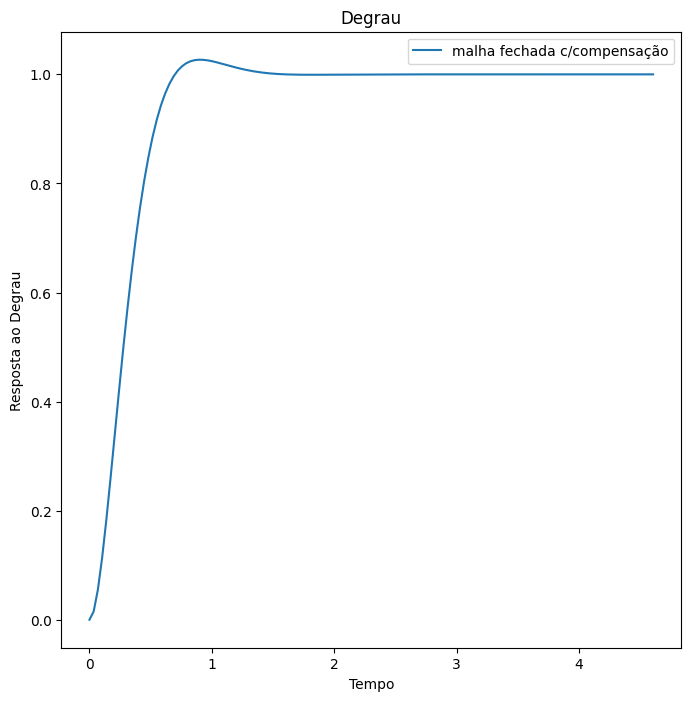

In [45]:
# Plot da resposta ao degrau
obter_plot_degrau({"malha fechada c/compensação":malha_fechada}, amortecimento=0.02)

> 5. Reajuste

Por recomendação do professor, isso não seria o suficiente. Apesar de respeitar os requisitos, o controlador estaria muito violento o que, provavelmente, causaria problemas. De fato, houve ressonância.

A recomendação foi posicionar o zero em -1 e ajustar o ganho até cumprir os requisitos. Por isso, abaixo definimos a variável k para ajustes e encontramos um bom comportamento e $k=0.01$

In [10]:
k = 0.01
num, den = obter_compensador_LR2([28.0796], [1, 3, 20.223], polos_add=[1, 1, 0], zeros_add=[k*1, k*3, k*20.223])


 Sua malha sem compensador é:
 
      28.08
-----------------
s^2 + 3 s + 20.22


 Seu compensador é:
 
0.01 s^2 + 0.03 s + 0.2022
--------------------------
         s^2 + s


 Seu sistema compensado é:
 
  0.2808 s^2 + 0.8424 s + 5.679
---------------------------------
s^4 + 4 s^3 + 23.22 s^2 + 20.22 s



In [11]:
malha_aberta  = ct.TransferFunction(num, den)
malha_fechada = ct.feedback(malha_aberta, 1)
malha_fechada

TransferFunction(array([0.280796  , 0.842388  , 5.67853751]), array([ 1.        ,  4.        , 23.503796  , 21.065388  ,  5.67853751]))

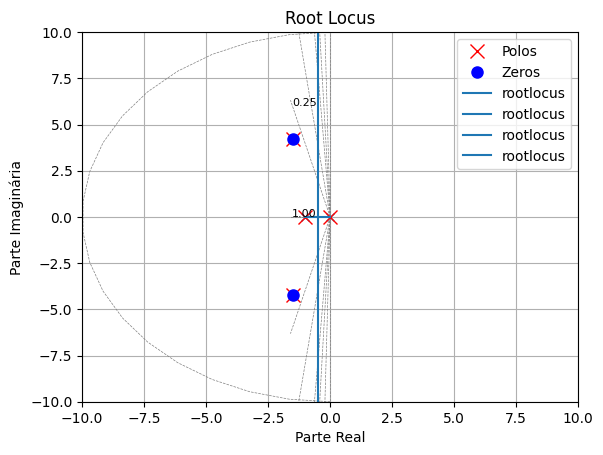


 Polos : 
-1.5000+4.2395j
-1.5000-4.2395j
-1.0000+0.0000j
0.0000+0.0000j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [12]:
obter_lugar_raizes(num, den, l_inf=10, l_sup=10)

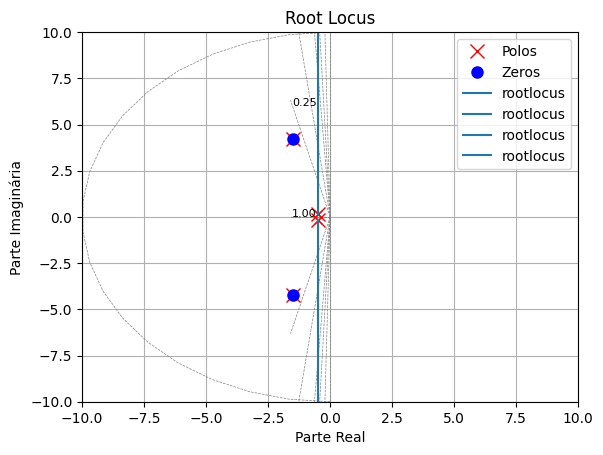


 Polos : 
-1.5000+4.2395j
-1.5000-4.2395j
-0.5000+0.1755j
-0.5000-0.1755j

 Zeros : 
-1.5000+4.2395j
-1.5000-4.2395j


In [13]:
obter_lugar_raizes(malha_fechada.num, malha_fechada.den, l_inf=10, l_sup=10)

                    Valor
Parâmetro                
RiseTime           5.8493
SettlingTime       9.8046
SettlingMin        0.9019
SettlingMax        1.0000
Overshoot          0.0000
Undershoot         0.0000
Peak               0.9989
PeakTime          13.8155
SteadyStateValue   1.0000


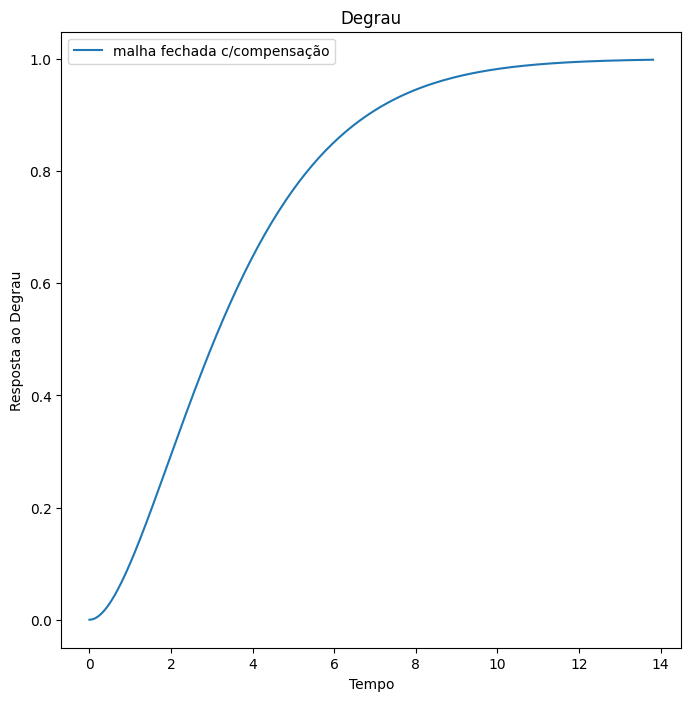

In [14]:
# Plot da resposta ao degrau
obter_plot_degrau({"malha fechada c/compensação":malha_fechada}, amortecimento=0.02)

> 6. Discretização

In [15]:
obter_z([k*1, k*3, k*20.223], [1, 1, 0], Ts=0.1 )

Coeficientes do compensador discreto:
Numerador: [[ 0.01143388 -0.01808462  0.00857674]]
Denominador: [ 1.        -1.9047619  0.9047619]


> 7. Análise dos testes

In [16]:
# Ler o arquivo CSV
dataframe = pd.read_csv('a5-lr.csv', sep=';', header=None)

# Adicionar cabeçalhos ao dataframe
dataframe.columns = ['tempo', 'VP', 'SC', 'SP']

# Reordenar as colunas
dataframe = dataframe[['tempo', 'VP', 'SP', 'SC']]

# Salvar o dataframe de volta no arquivo CSV — alteração para correto posicionamento das colunas
dataframe.to_csv('a5-lr-alterado.csv', sep=';', index=False, header=False)

# Exibir os primeiros itens do dataframe
dataframe.head()

,tempo,VP,SP,SC
0,0,"2,97",3,"6,29"
1,"0,1","2,95",3,"6,29"
2,"0,2","2,92",3,"6,3"
3,"0,3","2,95",3,"6,29"
4,"0,4","2,91",3,"6,3"


In [1]:
_, _, _, sinais = obter_dados_estruturados3('a5-lr-alterado.csv')
degrau_empirico({'primeira amostra':sinais[1],  'segunda amostra':sinais[3]}, x='tempo', y='SC', show=False, xlim=500, ylim=500)
degrau_simulado({'sistema calculado ': [malha_fechada.num, malha_fechada.den]}, x_start=0, y_start=0, xlim=500, ylim=500, show=False, step=1)

NameError: name 'obter_dados_estruturados3' is not defined

# <font style='font-size: 30px;'> Análise frequencial — Compensador de avanço </font> <hr style='line: 2px solid;'>

> 1. Calcule $\alpha$ e $T$ para seu compensador — ganho já foi calculado

In [4]:
malha_aberta = obter_objetos_TF(zeta=0.3346, wn=4.4971, k=1.3885*35.2899)
malha_aberta['control']

Zeros:
Polos:
-1.5047+4.2379j
-1.5047-4.2379j


TransferFunction(array([990.97204095]), array([ 1.        ,  3.00945932, 20.22390841]))

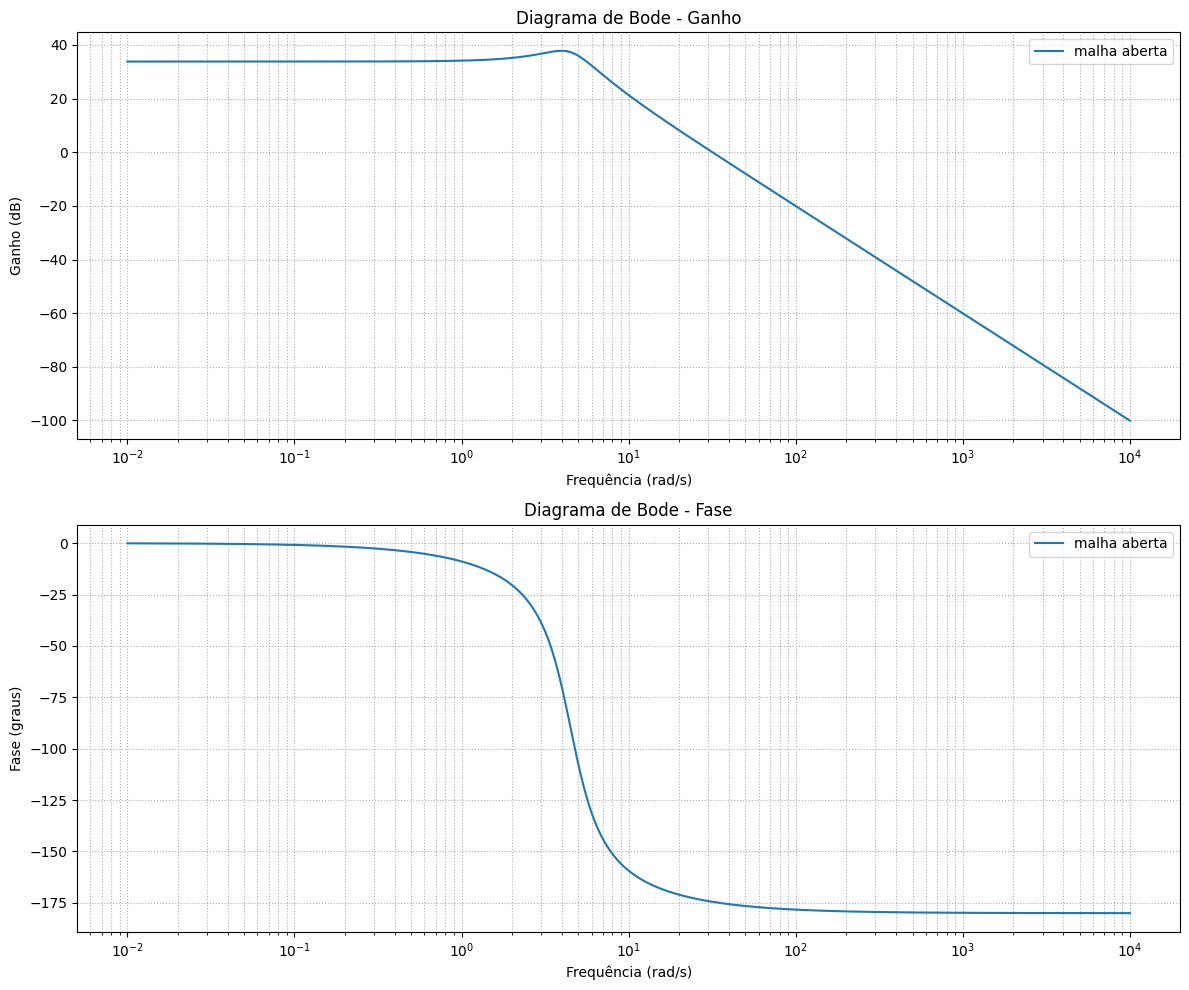

In [5]:
obter_plot_bode({"malha aberta":malha_aberta['scipy']})

Observando as *margens* do sistema, podemos ver que a frequência de margem de fase é de $\boxed{31.7267 \frac{rad}{s}}$, cuja fase é -174°

Na literatura (*Ogata, 5°Ed, figura 7.91*), podemos ver que o diagrama polar desse tipo de compensador fornece duas relações interessantes para cálculo, a saber:

$\phi_m$, fase máxima:
$$ \sin{\phi_m} = \frac{1-\alpha}{1+\alpha} $$

$\omega_m$, ganho máxima:
$$ |C(j\omega_m)| = \frac{1}{\sqrt{\alpha}} $$

Considerando nosso requisito de fase, $55° -5.5290°+10°=59.5°$, precisamos que $\phi_m=58.5°$. Logo temos:

$$ sen (53°) = 0.0.7986 = \frac{1-\alpha}{1+\alpha} → \boxed{\alpha = 0.0743} $$

Agora, podemos calcular também o máximo de ganho que nosso compensador pode fornecer:

$$ |C(j\omega_m)| = \frac{1}{\sqrt{8.9305}} →  \boxed{|C(j\omega_m)| = 3.6686 dB}$$

Então, o que queremos é que o modulo do sistema seja $|G(j\omega)| = -3.6686 dB$, e vamos buscar a frequência para esse ganho.

Ou seja, nossa nova frequência de corte será $32.2484 \frac{rad}{s}$, pois se o cruzamento for $\omega_m$, o ganho do compesador vai zerar com o ganho do sistema. Para garantir isso, precisamos encontrar o $T$ que faça isso, assim:

$$\omega_m = \frac{1}{\sqrt{\alpha}T} → \boxed{T = 0.0103}$$

Logo nosso compensador será:

In [6]:
malha_aberta_comp = obter_compensador_FREQ(malha_aberta['control'].num, malha_aberta['control'].den, alpha=0.0743, T=0.0935, kc=1)

# Cuidado para não fazer chamadas recursivas!


 CONTROLADOR:
 
 0.0935 s + 1
--------------
0.006947 s + 1


 SISTEMA S/CONTROLADOR:
 
         991
---------------------
s^2 + 3.009 s + 20.22


 SISTEMA C/CONTROLADOR:
 
              92.66 s + 991
-----------------------------------------
0.006947 s^3 + 1.021 s^2 + 3.15 s + 20.22



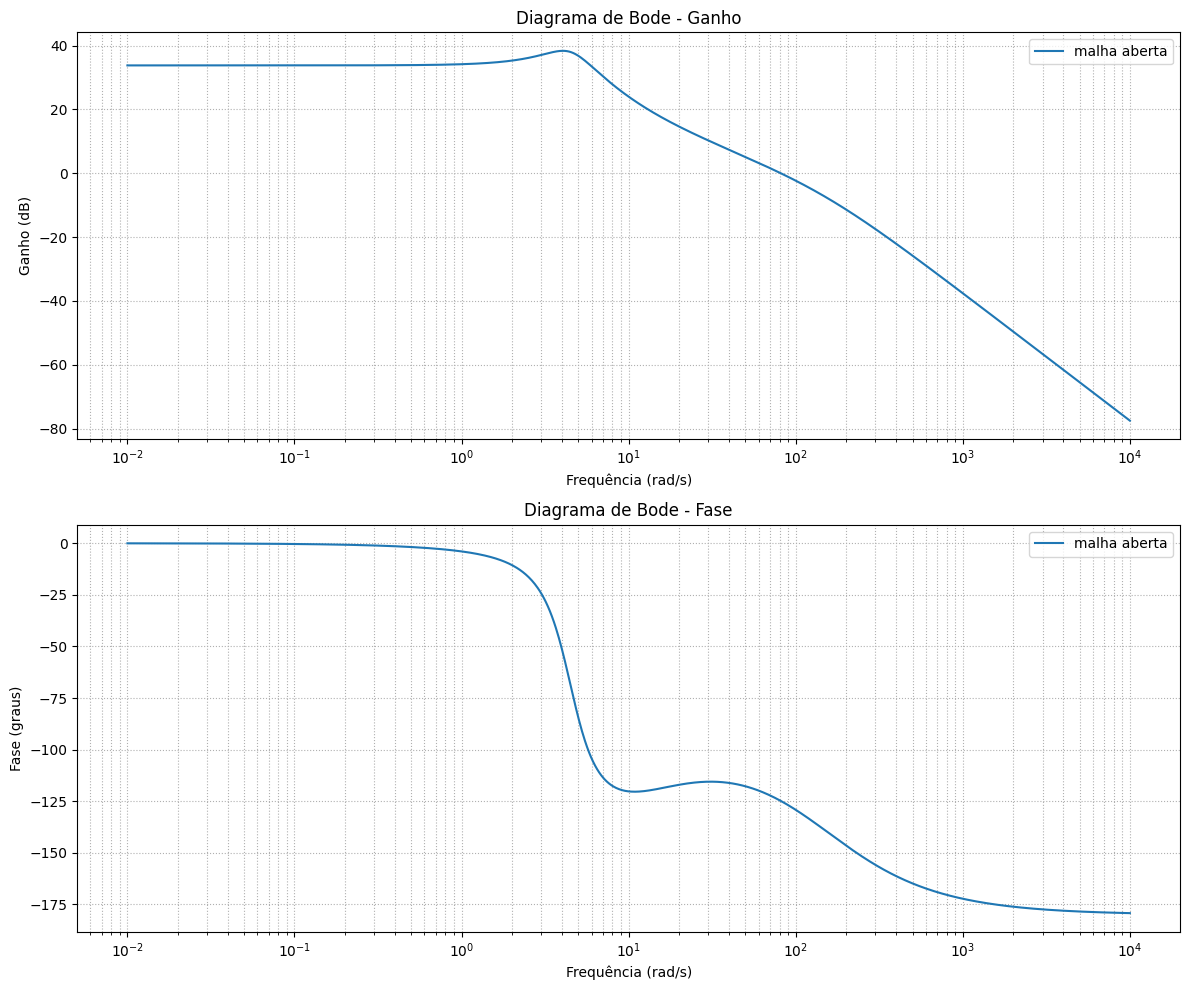

In [7]:
obter_plot_bode({'malha aberta':malha_aberta_comp['scipy']})

> 2. Obtenha a resposta degrau

Zeros:
-10.6952+0.0000j
Polos:
-67.5011+87.2969j
-67.5011-87.2969j
-11.9533+0.0000j


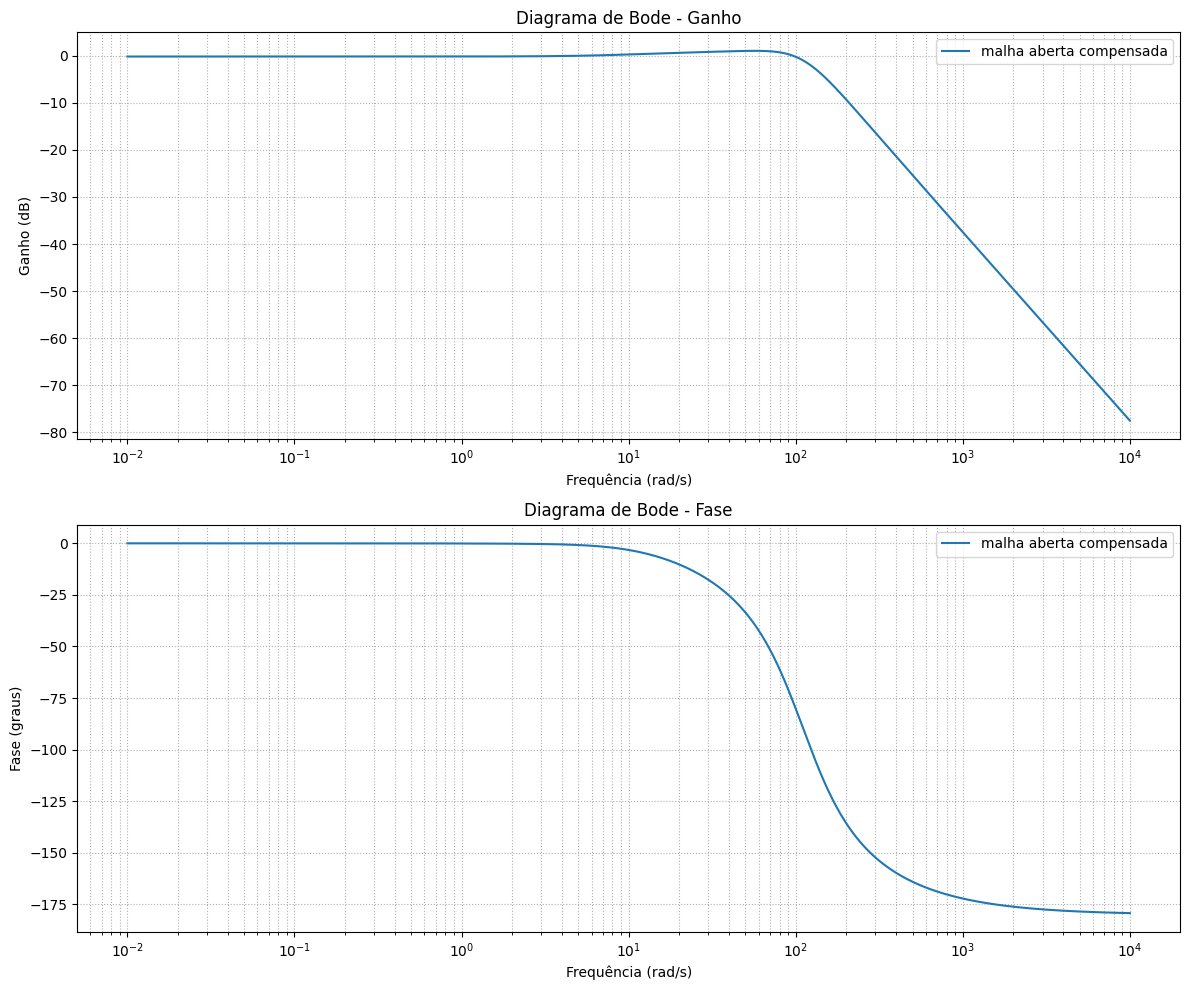

In [8]:
malha_fechada_comp = ct.feedback(malha_aberta_comp['control'], 1)
malha_fechada = obter_objetos_TF(num=malha_fechada_comp.num[0][0], den=malha_fechada_comp.den[0][0])
obter_plot_bode({'malha aberta compensada':malha_fechada['scipy']})

> 3. Simular resposta ao degrau

In [9]:
parametros = obter_plot_degrau({'planta de pressão fechada':malha_fechada['control']}, amortecimento=0.02)
parametros

NameError: name 'obter_plot_degrau' is not defined

> 4. Reajuste

Após os calculos, consegui encontrar um controle que satisfez os requisitos. Mas, antes mesmo de testar o professor recomendou — com base na literatura — que adicionassemos um ganho até atenuar em -40 dB na frequência de pico. Fiz e o resultado foi o compensador bem comportado.

In [10]:
malha_aberta_comp = obter_compensador_FREQ(num=[28.08], den=[1, 3, 20.22], ki=0.08)

# Cuidado para não fazer chamadas recursivas!


 CONTROLADOR:
 
0.08
----
 s


 SISTEMA S/CONTROLADOR:
 
      28.08
-----------------
s^2 + 3 s + 20.22


 SISTEMA C/CONTROLADOR:
 
        2.246
---------------------
s^3 + 3 s^2 + 20.22 s



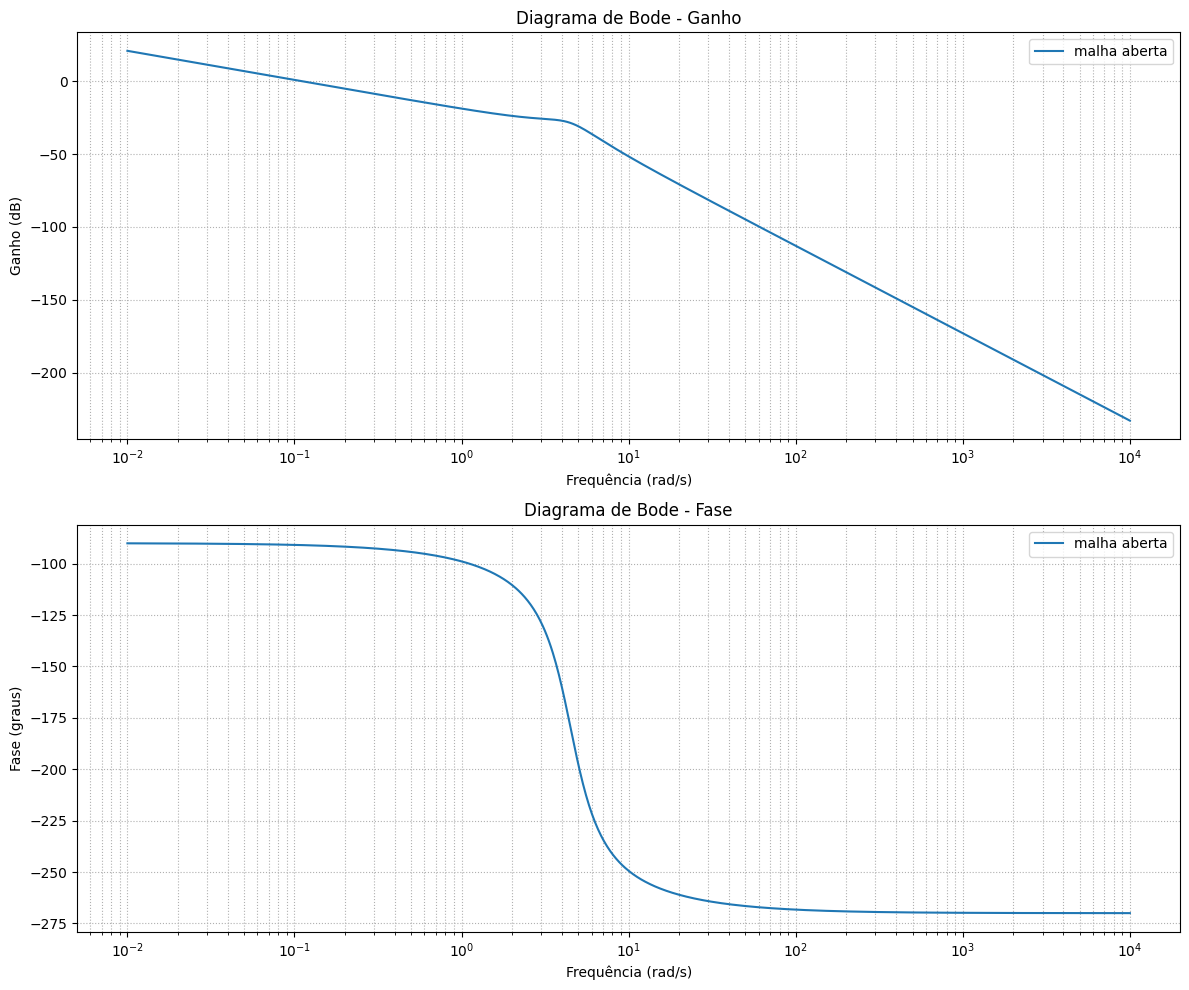

In [19]:
obter_plot_bode({'malha aberta':malha_aberta_comp['scipy']})

Zeros:
Polos:
-1.4435+4.2202j
-1.4435-4.2202j
-0.1129+0.0000j


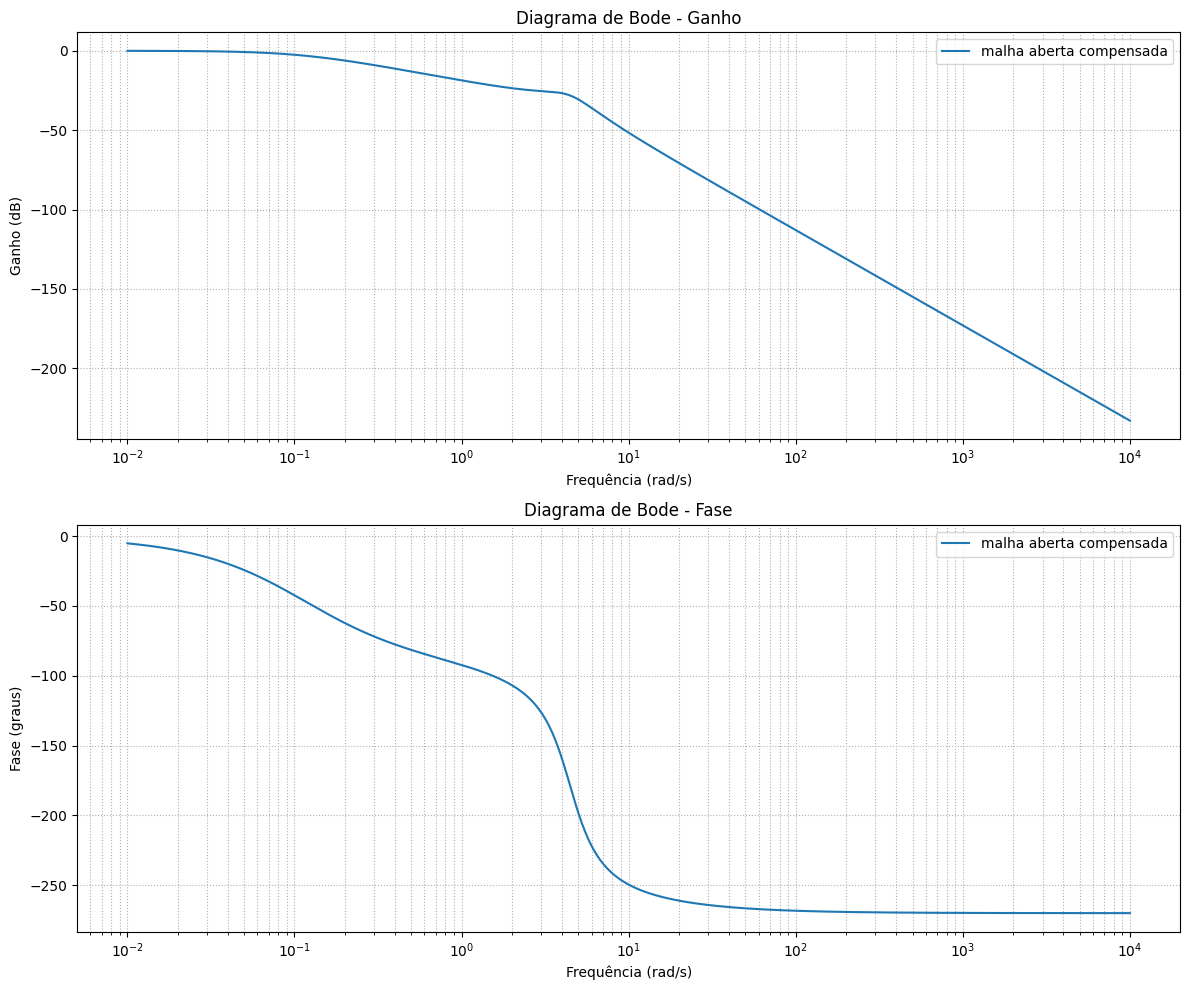

In [23]:
malha_fechada_comp = ct.feedback(malha_aberta_comp['control'], 1)
malha_fechada = obter_objetos_TF(num=malha_fechada_comp.num[0][0], den=malha_fechada_comp.den[0][0])
obter_plot_bode({'malha aberta compensada':malha_fechada['scipy']})

In [21]:
obter_plot_bode({'malha aberta compensada':malha_fechada_avanco['scipy']})
obter_valor_bode(malha_fechada_avanco['scipy'], criterio='ganho', valor=-40, resolucao=1000)
malha_fechada_avanco['control']

NameError: name 'malha_fechada_avanco' is not defined

In [22]:
parametros = obter_plot_degrau({'planta de pressão fechada':malha_fechada['control']}, amortecimento=0.02)
parametros

NameError: name 'obter_plot_degrau' is not defined

> 5. Discretização do controlador para testes

In [134]:
obter_z([0.08], [1,0], Ts=0.1)

Coeficientes do compensador discreto:
Numerador: [[0.004 0.004]]
Denominador: [ 1. -1.]


> 6. Análise dos testes

In [14]:
# Ler o arquivo CSV
dataframe = pd.read_csv('a5-rf.csv', sep=';', header=None)

# Adicionar cabeçalhos ao dataframe
dataframe.columns = ['tempo', 'VP', 'SC', 'SP']

# Reordenar as colunas
dataframe = dataframe[['tempo', 'VP', 'SP', 'SC']]

# Salvar o dataframe de volta no arquivo CSV — alteração para correto posicionamento das colunas
dataframe.to_csv('a5-rf-alterado.csv', sep=';', index=False, header=False)

# Exibir os primeiros itens do dataframe
dataframe.head()

,tempo,VP,SP,SC
0,0,"2,87",3,"6,22"
1,"0,1","2,82",3,"6,22"
2,"0,2","2,86",3,"6,22"
3,"0,3","2,87",3,"6,22"
4,"0,4","2,87",3,"6,22"


In [24]:
_, _, _, sinais = obter_dados_estruturados3('a5-rf-alterado.csv')
degrau_empirico({'primeira amostra':sinais[1],  'segunda amostra':sinais[3]}, 
                x='tempo', y='SC', show=False, xlim=500, ylim=500)
degrau_simulado({'sistema calculado ': [malha_fechada['control'].num, malha_fechada['control'].den]}, 
                x_start=0, y_start=0, xlim=500, ylim=500, show=False, step=1)

NameError: name 'obter_dados_estruturados3' is not defined

# <font style='font-size: 30px;'> Funções </font> <hr style='line: 2px solid;'>

In [3]:
# Imports

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import scipy.signal as signal
import numpy as np
import pandas as pd
import control as ct
import scipy as sp
import warnings
import cmath
from scipy.signal import cont2discrete
import sympy


def obter_conjulgados_dominantes(Mp, Ts, xi=None):
    """
    Função para obter o compensador de avanço de um sistema.
    
    Parâmetros:
    - Mp : sobressinal desejado no caso de sistemas de 1º ordem
    - Ts : tempo de acomodação desejado
    - xi : se for passado, a função ignorará Mp. Usado para sistemas de 2º ordem
    
    Retorno:
    - dois polos complexos e conjulgados que passam nas especificações
    """

    if xi == None:
        xi = -np.log(Mp) / np.sqrt(np.pi**2 + np.log(Mp)**2)
    wn = 4 / (Ts * xi)
    wd = wn * np.sqrt(1 - xi**2)
    pole1 = complex(-xi*wn, wd)
    pole2 = complex(-xi*wn, -wd)
    pole1 = np.round(pole1, decimals=4)  # Arredondar o polo1 para 3 casas decimais
    pole2 = np.round(pole2, decimals=4)  # Arredondar o polo2 para 3 casas decimais
    return [pole1, pole2]

def obter_defasagem_angular_compensador(num, den, s, delta=0, compensador='avanço', matar_polos=False):
    """
    Função para obter o compensador de avanço ou atraso de um sistema.

    Parâmetros:
    - num: array numerador do seu sistema
    - den: array denominador do seu sistema
    - s: 1 polo complexo de referência
    - delta (opcional): ajuste da posição do zero ou polo de referência
    - compensador (opcional): tipo de compensador, 'avanço' ou 'atraso'

    Retorno:
    - dois polos complexos e conjugados que passam nas especificações
    """

    # Obter os polos e zeros da função de transferência
    polos = np.roots(den)
    zeros = np.roots(num)

    # Adicionar o zero ou polo de referência
    if compensador == 'avanço':
        zeros = np.append(zeros, s.real+delta)
    elif compensador == 'atraso':
        polos = np.append(polos,complex(-0.01+delta))

    # Cancelar os polos, se necessário
    if matar_polos:
        zeros = np.append(zeros, polos)
    
    # Calcular a defasagem angular
    phi = 180

    # Calcular contribuição dos polos
    i = 1
    for polo in polos:
        angulo = np.angle(s - polo, deg=True)
        print(f"{i}° Polo, {polo:.4f}, faz {angulo:.1f}° com o S")
        phi -= angulo
        i += 1

    # Calcular contribuição dos zeros
    i = 1
    for zero in zeros:
        angulo = np.angle(s - zero, deg=True)
        print(f"{i}° Zero, {zero:.4f}, faz {angulo:.1f}° com o S")
        phi += angulo
        i += 1

    print(f" \n Polo do compensador precisa compensar: {phi:.1f}°")

def degrau_empirico(sinais, x_start=0, y_start=0, x='tempo', y='saida', xlim=100, ylim=100, show=True, interp1d=False, legend=True, plot=True):

    # Ainda precisa de implementação
    
    if interp1d:

        f = interp1d(x, y)

        # Encontra o valor mínimo de x
        x_min = np.min(x)
        x_max = np.max(x)

        # Cria um novo conjunto de pontos com maior resolução
        t_real = np.linspace(x_min, x_max, 1000)
        y_real = f(t_real)

    if plot:

        for chave, valor in sinais.items():
            tempo = valor[x]
            saida = valor[y]

            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - saida[0]

            plt.plot(tempo + deslocamento_x, saida + deslocamento_y, label=chave)
        return

    with plt.ioff():

        fig = plt.figure()
        ax = fig.add_subplot()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

        for chave, valor in sinais.items():
            tempo = valor[x]
            saida = valor[y]

            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - saida[0]

            ax.plot(tempo + deslocamento_x, saida + deslocamento_y, label=chave)

        if legend:

            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_title('Resposta ao degrau unitário')
            ax.grid()
            plt.legend()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

    if show:
        plt.show()
    else:
        return ax

def degrau_simulado(sistemas, x_start=0, y_start=0, xlim=100, ylim=100, show=True, legend=True, plot=True, step=1):

    if plot:

        for nome, coeficientes in sistemas.items():
            num, den = coeficientes
            sys = ct.TransferFunction(num, den)
            tempo, resposta = ct.step_response(sys)
            
            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - resposta[0]
            
            plt.plot(tempo + deslocamento_x, step*(resposta + deslocamento_y), label=nome)
        return 

    with plt.ioff():

        fig, ax = plt.subplots(figsize=(10, 10))

        for nome, coeficientes in sistemas.items():
            num, den = coeficientes
            sys = ct.TransferFunction(num, den)
            tempo, resposta = ct.step_response(sys)
            
            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - resposta[0]
            
            ax.plot(tempo + deslocamento_x, resposta + deslocamento_y, label=nome)

        if legend:

            ax.set_xlabel('Tempo')
            ax.set_ylabel('Resposta ao Degrau')
            ax.set_title('Degrau')
            ax.grid(True)
            ax.legend()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

    if show:
        plt.show()
    else:
        return ax



# Análise de Lugar das raízes


def obter_compensador_LR2(num, den, s, polos_add=None, zeros_add=None, p_c=None, phi_z=None, z_c=None, phi_p=None):
    """
    Função para obter o compensador de avanço ou atraso de um sistema.
    
    Parâmetros:
    - k: ganho do seu controlador
    - num: lista dos coeficientes do numerador da função de transferência
    - den: lista dos coeficientes do denominador da função de transferência
    - s: número complexo alvo para referência
    - p_c: polo do compensador
    - z_c: zero do compensador
    - phi_p: ângulo interno que polo do compensador faz com s
    - phi_z: ângulo interno que zero do compensador faz com s
    
    Retorno:
    - Prints do compensador, sistema não compensado e sistema compensado.
    
    """

    if polos_add and zeros_add is not None:
        compensador = ct.TransferFunction(zeros_add, polos_add)
    
    else:
        if p_c is not None:
            # Encontrar zero (compensador de atraso)
            z_c = (s.imag/np.tan(phi_z * (np.pi/180))) - s.real
            print(f"\n Seu zero está em: {(z_c.real):.4f}")
        elif z_c is not None:
            # Encontrar polo (compensador de avanço)
            p_c = (s.imag/np.tan(phi_p * (np.pi/180))) - s.real
            print(f"\n Seu polo está em: {(p_c.real):.4f}")
        else: raise ("Não pode haver polo e zero nulo ao mesmo tempo. Escolha um")

        # Obter polos e zeros da função de transferência
        polos = ct.pole(ct.TransferFunction(num, den))
        zeros = ct.zero(ct.TransferFunction(num, den))
        
        # Calcular o módulo dos termos
        num_eval = 1
        for zero in zeros:
            num_eval *= np.abs(zero + s)

        den_eval = 1
        for polo in polos:
            den_eval *= np.abs(polo + s)

        # Verificando condição de módulo
        k_c = den_eval/num_eval
        print(f"\n Você precisa multiplicar por: {(k_c):.4f} para satisfazer a condição de módulo")

        compensador = ct.TransferFunction([k_c, k_c*np.abs(z_c.real)], [1, np.abs(p_c.real)])


    sistema = ct.TransferFunction(num, den)
    sistema_compensado = sistema * compensador

    # Imprimir a função de transferência do compensador e os sistemas
    print(f"\n CONTROLADOR:\n {compensador}")
    print(f"\n SISTEMA S/CONTROLADOR:\n {sistema}")
    print(f"\n SISTEMA C/CONTROLADOR:\n {sistema_compensado}")

    return sistema_compensado

def obter_lugar_raizes(num, den, l_inf=10, l_sup=10):
    
    system = ct.TransferFunction(num, den)
    poles, zeros = ct.pzmap(system, plot=False)
    
    if len(poles) == 0:
        print("Não há polos no sistema.")
        return

    fig, ax = plt.subplots()

    # rlist, klist = ct.root_locus(system, plot=False)
    rlist, klist = ct.root_locus(system, plot=True, ax=ax)

    ax.plot(np.real(poles), np.imag(poles), 'rx', markersize=10, label='Polos')
    ax.plot(np.real(zeros), np.imag(zeros), 'bo', markersize=8, label='Zeros')

    ax.set_xlim([-l_inf, l_sup])  # Define o limite do eixo x
    ax.set_ylim([-l_inf, l_sup])  # Define o limite do eixo y

    plt.legend()
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginária')
    plt.grid(True)
    plt.show()

    print("\n Polos : ")
    for polo in poles:
        print(f"{polo:.4f}")
    
    print("\n Zeros : ")
    for zero in zeros:
        print(f"{zero:.4f}")

    #print("\n Ganho crítico (ganho no ponto de ruptura):", np.abs(klist[-1]))


# Análise Frequêncial


def obter_plot_bode(sistemas):
    
    # Frequências para o cálculo do Bode
    w = np.logspace(-2, 4, num=1000)

    # Criação dos subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    for name, sistema in sistemas.items():

        # Obter os dados do diagrama de Bode
        omega, mag, phase = signal.bode(sistema,w=w)

        # Plot do diagrama de ganho
        ax1.semilogx(omega, mag, label=name)

        # Plot do diagrama de fase
        ax2.semilogx(omega, phase, label=name)

    ax1.set_xlabel('Frequência (rad/s)')
    ax1.set_ylabel('Ganho (dB)')
    ax1.set_title('Diagrama de Bode - Ganho')
    ax1.grid(True, which='both', linestyle='dotted')
    ax1.legend()

    ax2.set_xlabel('Frequência (rad/s)')
    ax2.set_ylabel('Fase (graus)')
    ax2.set_title('Diagrama de Bode - Fase')
    ax2.grid(True, which='both', linestyle='dotted')
    ax2.legend()

    plt.tight_layout()
    plt.show()

def obter_compensador_FREQ(num, den, ki=None, alpha=None, T=None, kc=None):
    
    sistema = ct.TransferFunction(num, den)

    if ki is not None:
        controlador = ct.TransferFunction([ki],[1, 0])
    else:
        num_comp = [kc*T, kc*1]
        den_comp = [alpha * T, 1]
        controlador = ct.TransferFunction(num_comp, den_comp)

    sistema_compensado_control = sistema * controlador

    # Imprimir a função de transferência do compensador e os sistemas
    print(f"\n CONTROLADOR:\n {controlador}")
    print(f"\n SISTEMA S/CONTROLADOR:\n {sistema}")
    print(f"\n SISTEMA C/CONTROLADOR:\n {sistema_compensado_control}")
    
    num_comp=sistema_compensado_control.num
    den_comp=sistema_compensado_control.den
    sistema_compensado_scipy = signal.TransferFunction(num_comp[0][0], den_comp[0][0])

    return {'scipy':sistema_compensado_scipy, 'control':sistema_compensado_control}

def obter_compensador_FREQ_margins(num, den):

    ct_tf = ct.TransferFunction(num, den)
    gm, pm, wg, wp = ct.margin(ct_tf)

    df = pd.DataFrame(columns=['Margem de Ganho (dB)', 'Margem de Fase (graus)', 'Frequência de Margem de Ganho (rad/s)', 'Frequência de Margem de Fase (rad/s)'])
    if alpha > 1:   df.loc['Compensador de atraso'] = [gm, pm, wg, wp]
    elif alpha < 1: df.loc['Compensador de avanço'] = [gm, pm, wg, wp]
    else:           df.loc['Não é compensador'] = [gm, pm, wg, wp]
    ct_tf


# Manipuladores


def obter_z(num, den, Ts):

    # Converte o compensador usando o método de Tustin
    num_d, den_d, _ = cont2discrete((num, den), Ts, method='tustin')

    # Exibe os coeficientes do compensador discreto
    print("Coeficientes do compensador discreto:")
    print("Numerador:", num_d)
    print("Denominador:", den_d)

def degrau_empirico(sinais, x_start=0, y_start=0, x='tempo', y='saida', xlim=100, ylim=100, show=True, interp1d=False, legend=True, plot=True):

    # Ainda precisa de implementação
    
    if interp1d:

        f = interp1d(x, y)

        # Encontra o valor mínimo de x
        x_min = np.min(x)
        x_max = np.max(x)

        # Cria um novo conjunto de pontos com maior resolução
        t_real = np.linspace(x_min, x_max, 1000)
        y_real = f(t_real)

    if plot:

        for chave, valor in sinais.items():
            tempo = valor[x]
            saida = valor[y]

            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - saida[0]

            plt.plot(tempo + deslocamento_x, saida + deslocamento_y, label=chave)
        return

    with plt.ioff():

        fig = plt.figure()
        ax = fig.add_subplot()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

        for chave, valor in sinais.items():
            tempo = valor[x]
            saida = valor[y]

            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - saida[0]

            ax.plot(tempo + deslocamento_x, saida + deslocamento_y, label=chave)

        if legend:

            ax.set_xlabel(x)
            ax.set_ylabel(y)
            ax.set_title('Resposta ao degrau unitário')
            ax.grid()
            plt.legend()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

    if show:
        plt.show()
    else:
        return ax

def degrau_simulado(sistemas, x_start=0, y_start=0, xlim=100, ylim=100, show=True, legend=True, plot=True, step=1):

    if plot:

        for nome, coeficientes in sistemas.items():
            num, den = coeficientes
            sys = ct.TransferFunction(num, den)
            tempo, resposta = ct.step_response(sys)
            
            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - resposta[0]
            
            plt.plot(tempo + deslocamento_x, step*(resposta + deslocamento_y), label=nome)
        return 

    with plt.ioff():

        fig, ax = plt.subplots(figsize=(10, 10))

        for nome, coeficientes in sistemas.items():
            num, den = coeficientes
            sys = ct.TransferFunction(num, den)
            tempo, resposta = ct.step_response(sys)
            
            deslocamento_x = x_start - tempo[0]
            deslocamento_y = y_start - resposta[0]
            
            ax.plot(tempo + deslocamento_x, resposta + deslocamento_y, label=nome)

        if legend:

            ax.set_xlabel('Tempo')
            ax.set_ylabel('Resposta ao Degrau')
            ax.set_title('Degrau')
            ax.grid(True)
            ax.legend()

        ax.set_xlim(0, xlim)
        ax.set_ylim(0, ylim)

    if show:
        plt.show()
    else:
        return ax

def obter_dados_estruturados(nome_arquivo):
    # Carrega os dados do arquivo CSV para um DataFrame
    df_real = pd.read_csv(nome_arquivo, sep=';', decimal=',')

    # Criando as listas vazias para armazenar os arrays
    tempo_list = []
    vp_list = []
    sc_list = []
    estrutura_list = []

    # Variáveis para guardar os valores temporários
    tempo = []
    vp = []
    sc = []

    # Variável para armazenar o último valor de SP
    last_sp = df_real.iloc[0, 2]

    # Loop pelas linhas do DataFrame
    for i, row in df_real.iterrows():
        # Verifica se o valor de SP mudou — enquanto não tiver mudado, adicionamos no array.
        if row[2] != last_sp:
            # Adiciona os arrays de tempo, VP e SC nas respectivas listas
            tempo_list.append(np.array(tempo))
            vp_list.append(np.array(vp))
            sc_list.append(np.array(sc))
            # Cria o dicionário com a estrutura desejada
            estrutura = {'tempo': np.array(tempo), 'VP': np.array(vp), 'SC': np.array(sc)}
            estrutura_list.append(estrutura)
            # Reseta as variáveis de tempo, VP e SC
            tempo = []
            vp = []
            sc = []
            # Atualiza o valor de SP
            last_sp = row[2]
        # Adiciona os valores de tempo, VP e SC aos arrays temporários
        tempo.append(row[0])
        vp.append(row[1])
        sc.append(row[3])

    # Adiciona os últimos arrays de tempo, VP e SC às listas
    tempo_list.append(np.array(tempo))
    vp_list.append(np.array(vp))
    sc_list.append(np.array(sc))
    # Cria o dicionário com a estrutura desejada para o último conjunto de dados
    estrutura = {'tempo': np.array(tempo), 'VP': np.array(vp), 'SC': np.array(sc)}
    estrutura_list.append(estrutura)

    return tempo_list, vp_list, sc_list, estrutura_list

def obter_objetos_TF(zeta=None, wn=None, k=1, num=None, den=None):
    if num is not None and den is not None:
        sc_tf = signal.TransferFunction(k*num, den)
        ct_tf = ct.TransferFunction(k*num, den)
    elif zeta is not None and wn is not None and k is not None:
        num = [k*wn**2]
        den = [1, 2*zeta*wn, wn**2]
        sc_tf = signal.TransferFunction(num, den)
        ct_tf = ct.TransferFunction(num, den)
    else:
        raise ValueError("É necessário fornecer os coeficientes da função de segunda ordem ou os coeficientes num e den.")

    print("Zeros:")
    zeros = np.round(ct.zero(ct_tf), 4)
    for zero in zeros:
        print(f"{zero.real:+.4f}{zero.imag:+.4f}j")
    print("Polos:")
    polos = np.round(ct.pole(ct_tf), 4)
    for polo in polos:
        print(f"{polo.real:+.4f}{polo.imag:+.4f}j")
    
    return {"scipy":sc_tf, "control":ct_tf}



# def obter_parametros_sistema(num=None, den=None, sys=None, acomodacao=0.02):
#     if sys is not None:
#         sistema = sys
#     elif num is not None and den is not None:
#         sistema = ct.TransferFunction(num, den)
#     else:
#         raise ValueError("É necessário fornecer o sistema ou o numerador e o denominador.")
#     info_sistema = ct.step_info(sistema, SettlingTimeThreshold=acomodacao)
#     df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
#     df_sistema.index.name = 'Parâmetro'
#     df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
#     e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', 'Valor']):.4f}")
#     df_adicional = pd.DataFrame({'Valor': [e_ss_atual]}, index=['Erro(%)'])
#     df_sistema = pd.concat([df_sistema, df_adicional])
#     # df_sistema = df_sistema.drop(['SettlingMin', 'SettlingMax', 'Undershoot'])
#     return df_sistema

# def obter_plot_degrau(transfer_functions, amortecimento=0.02):
    
#     fig, ax = plt.subplots(figsize=(8, 8))

#     for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
#         info_sistema = ct.step_info(transfer_function, SettlingTimeThreshold=amortecimento)
#         df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=['Valor'])
#         df_sistema.index.name = 'Parâmetro'
#         df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')

#         tempo, resposta = ct.step_response(transfer_function)
#         ax.plot(tempo, resposta, label=name)
#         print(df_sistema)

#     ax.set_xlabel('Tempo')
#     ax.set_ylabel('Resposta ao Degrau')
#     ax.set_title('Degrau')
#     ax.legend()

#     # plt.tight_layout()
#     plt.show()

# def obter_plot_degrau_2(transfer_functions, amortecimento=0.02):
    
#     fig, ax = plt.subplots(figsize=(8, 8))

#     for i, (name, transfer_function) in enumerate(transfer_functions.items()):
        
#         # obter resposta ao degrau unitário
#         tempo, resposta = ct.step_response(transfer_function)
#         ax.plot(tempo, resposta, label=name)

#         # obter informações
#         info_sistema = ct.step_info(transfer_function, SettlingTimeThreshold=amortecimento)
#         df_sistema = pd.DataFrame.from_dict(info_sistema, orient='index', columns=[name])
#         df_sistema.index.name = 'Parâmetro'

#         # Adicionar erro
#         e_ss_atual = float(f"{1 - float(df_sistema.at['SteadyStateValue', name])}")
#         df_adicional = pd.DataFrame({name: [e_ss_atual]}, index=['Erro(%)'])
#         df_sistema = pd.concat([df_sistema, df_adicional])
        
#         # arredondar para 4 decimais
#         df_sistema = df_sistema.applymap(lambda x: f'{x:.4f}')
#         print(f"\n {df_sistema}")

#     ax.set_xlabel('Tempo')
#     ax.set_ylabel('Resposta ao Degrau')
#     ax.set_title('Degrau')
#     ax.grid(True)
#     ax.legend()

#     # plt.tight_layout()
#     plt.show()

